# Fine Tuning with MobileNetV2 Backbone

In [3]:
import keras
import tensorflow as tf
import os, random, datetime
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models  import load_model

# Tensorflow ve Keras Libs
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Functions

In [4]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
        
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

def display_images(img_list):
    plt.figure(figsize=(15, 6))
    
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
        
    plt.tight_layout()
    plt.show()


def print_predicted_classes(predicted_classes):
    
    for full_path, (label, probability) in predicted_classes.items():
        filename = os.path.basename(full_path)
        print(f"{filename}: {label} ({probability:.2f}%)")

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

## Data Prep & Augmentation

In [3]:
dir_path = '../Garbage classification'
img_list = get_image_paths(dir_path)

len(img_list)

2527

In [4]:
# 501 glass
# 594 paper
# 403 cardboard
# 482 plastic
# 410 metal
# 137 trash

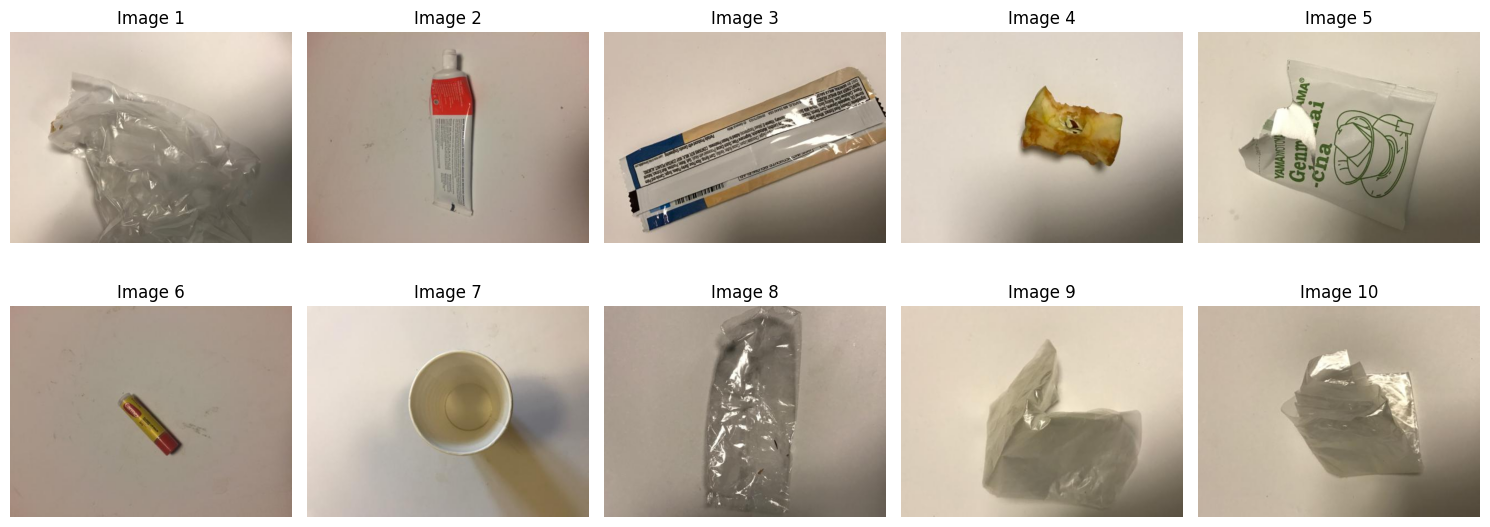

In [5]:
display_images(img_list[0:10])

In [6]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)


val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [7]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## Frozen Layers
### MobileNetV2 Backbone

In [8]:
mobilenet_backbone = MobileNetV2(weights='imagenet',

                                 include_top=False, # fully connected(top) layers will not be included!

                                 input_shape=(224, 224, 3))

#alpha=1.0: It determines how many filters in this architecture will be used. It takes values between 0-1.
#classes: If "include_top = True", we would give information about how many classes there are in our dataset with this parameter.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**NOTE:** <u>In my project, I compare several different models in terms of performance, train time and used sources and decide on one.</u>

In [9]:
mobilenet_backbone.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
print(f"Total number of layers in MobileNetV2: {len(mobilenet_backbone.layers)}")

Total number of layers in MobileNetV2: 154


In [11]:
block_count = 0

for layer in mobilenet_backbone.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) and 'expand' in layer.name:
        block_count += 1

print(f"Number of logical 'blocks' in MobileNetV2: {block_count}")

Number of logical 'blocks' in MobileNetV2: 17


In [12]:
for layer in mobilenet_backbone.layers:
    print(layer.name, layer.trainable)

input_layer True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_project True
blo

In [13]:
for layer in mobilenet_backbone.layers[-11:]:
    print(layer.name, layer.trainable)

block_16_expand True
block_16_expand_BN True
block_16_expand_relu True
block_16_depthwise True
block_16_depthwise_BN True
block_16_depthwise_relu True
block_16_project True
block_16_project_BN True
Conv_1 True
Conv_1_bn True
out_relu True


In [14]:
for layer in mobilenet_backbone.layers:
    layer.trainable = False

In [15]:
for layer in mobilenet_backbone.layers:
    print(layer.name, layer.trainable)

input_layer False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_dep

In [16]:
for layer in mobilenet_backbone.layers[-11:]: # son blok yapısını sondan 11nci katmandan itibaren olduğunu düşündük.
    layer.trainable = True

In [18]:
for layer in mobilenet_backbone.layers:
    print(layer.name, layer.trainable)

input_layer False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_dep

## Training

In [21]:
x = GlobalAveragePooling2D()(mobilenet_backbone.output) # mobilNet output has been reduced in size.

In [22]:
x = Dense(6, activation='softmax')(x) # A fully connected layer consisting of 6 neurons was added.

In [23]:
fine_tuning_model = Model(inputs=mobilenet_backbone.input, outputs=x)

In [24]:
metrics = ["accuracy", AUC(name='auc', multi_label=True)]

In [26]:
from tensorflow.keras.optimizers import SGD # stochastic gradient descent <=> minibatchh method
optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True) 
# momentum => is the parameter to take into account the gradient information from previous iterations.
# Nesterov acceleration method was used. It is a variant of Momentum.
# It is used to make the algorithm react faster and more rationally, especially in cases where the gradient changes direction. 
# The aim is to progress by minimally touching the original model.

In [27]:
fine_tuning_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)


model_checkpoint = ModelCheckpoint('mobilenetv2_finetuned.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [30]:
start_time = datetime.datetime.now()

# MODEL FINE-TUNE
fine_tuning_model_history = fine_tuning_model.fit(
    train_generator,
    epochs=3,
    # epochs = 50 # change the number and see different results 
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4294 - auc: 0.7113 - loss: 1.5010 
Epoch 1: val_loss improved from inf to 1.43120, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1137s 16s/step - accuracy: 0.4303 - auc: 0.7120 - loss: 1.4992 - val_accuracy: 0.3984 - val_auc: 0.7861 - val_loss: 1.4312
Epoch 2/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6041 - auc: 0.8510 - loss: 1.1175
Epoch 2: val_loss improved from 1.43120 to 1.20944, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.6046 - auc: 0.8513 - loss: 1.1166 - val_accuracy: 0.5538 - val_auc: 0.8578 - val_loss: 1.2094
Epoch 3/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6921 - auc: 0.9036 - loss: 0.9339
Epoch 3: val_loss improved from 1.20944 to 1.10610, saving model to mobilenetv2_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6922 - auc: 0.9037 - loss: 0.9334 - val_accuracy: 0.5936 - val_auc: 0.8884

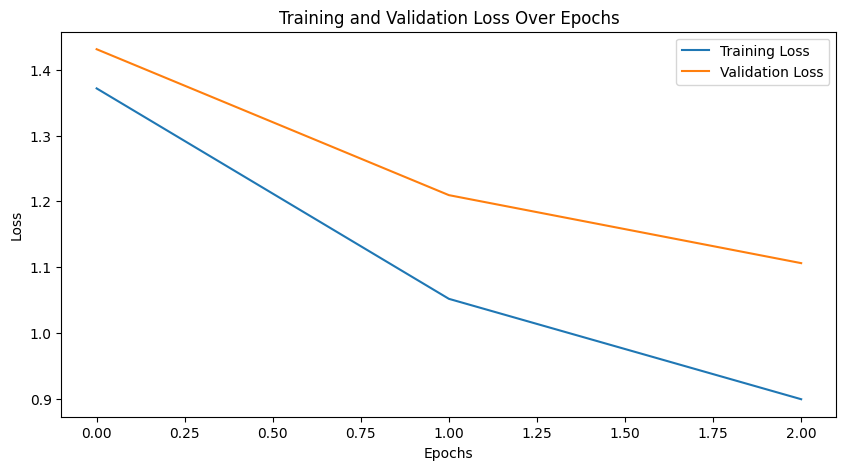

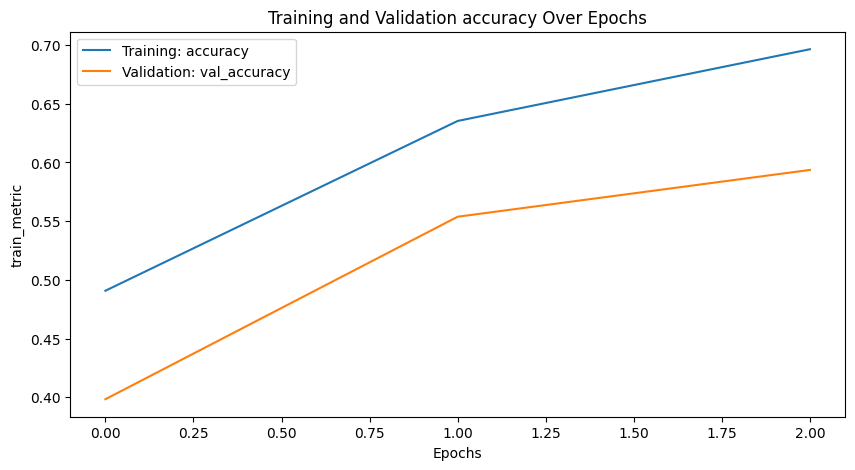

In [31]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

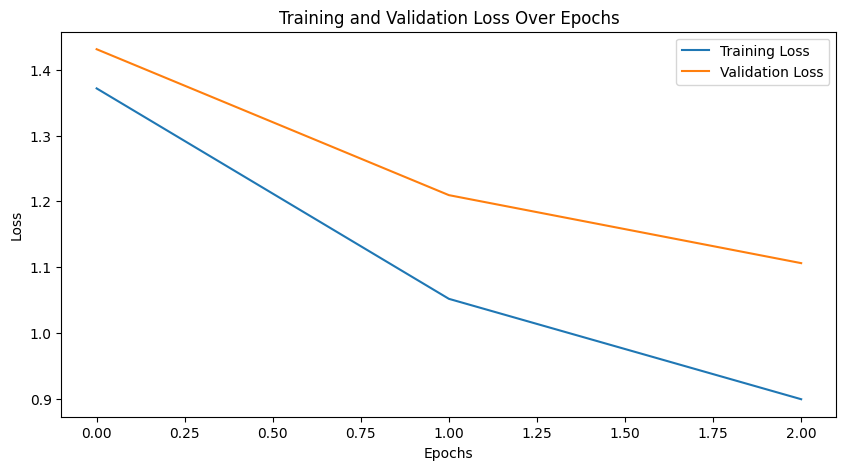

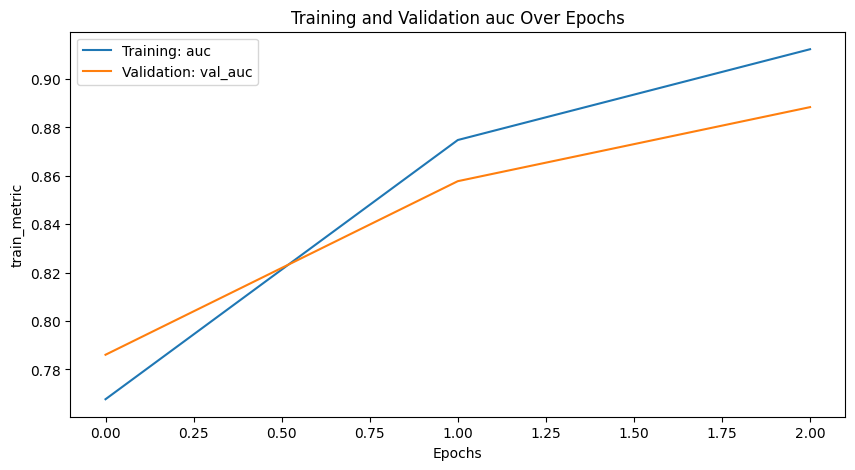

In [32]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

In [33]:
val_loss, val_accuracy, val_auc = fine_tuning_model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 1.1060980558395386
Accuracy: 0.5936254858970642
AUC: 0.8883787989616394


## Prediction & Inference

In [34]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [35]:
dir_path = '../Garbage classification'
img_list = get_image_paths(dir_path)

In [36]:
garbage_tuned_model = load_model('/content/mobilenetv2_finetuned.keras')

In [37]:
def preprocess_mobilenet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_mobilenetv2(img_array)
    return img_array

def predict_mobilenet(model, img_array, class_labels):
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    probability = np.max(predictions[0])
    return predicted_class, probability

def visualise_preds_mobilenet(model, image_paths, class_labels, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_mobilenet(img_path)
        label, probability = predict_mobilenet(model, img_array, class_labels)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [ ]:
predicted_classes = visualise_preds_mobilenet(garbage_tuned_model, img_list, waste_labels, True)

print_predicted_classes(predicted_classes)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# img_list2 = get_image_paths(dir_path, 50)
# predicted_classes2 = visualise_preds_mobilenet(garbage_tuned_model, img_list2, waste_labels, False)
# print_predicted_classes(predicted_classes2)

# Full Network Fine Tuning

## Data Preparation & Augmentation

In [5]:
dir_path = '../Garbage classification'
img_list = get_image_paths(dir_path)

len(img_list)

2527

In [6]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)


val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## Model

In [7]:
mobilenet_backbone_full = MobileNetV2(weights='imagenet',
                                 include_top=False,
                                 input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
for layer in mobilenet_backbone_full.layers:
    layer.trainable = True

In [9]:
x = GlobalAveragePooling2D()(mobilenet_backbone_full.output)

x = Dense(6, activation='softmax')(x)

In [10]:
full_network_fine_tuning = Model(inputs=mobilenet_backbone_full.input, outputs=x)

In [11]:
metrics = ["accuracy", AUC(name='auc', multi_label=True)]

In [12]:
from tensorflow.keras.optimizers import SGD
optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

full_network_fine_tuning.compile(optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

In [13]:
early_stopping_full = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)


model_checkpoint_full = ModelCheckpoint('mobilenetv2_full_network.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

## Training

In [1]:
start_time = datetime.datetime.now()

full_network_history = full_network_fine_tuning.fit(
    train_generator,
    # epochs=3,
    validation_data=validation_generator,
    callbacks=[early_stopping_full, model_checkpoint_full]
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

## Model Performance

In [ ]:
plot_training_history(full_network_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

In [ ]:
plot_training_history(full_network_history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

In [ ]:
val_loss, val_accuracy, val_auc = full_network_fine_tuning.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

## Prediction

In [ ]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [ ]:
dir_path = '../Garbage classification'
img_list = get_image_paths(dir_path)

len(img_list)

In [ ]:
garbage_full_tuned_model = load_model('mobilenetv2_full_network.keras')

In [ ]:
def preprocess_mobilenet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_mobilenetv2(img_array)
    return img_array

def predict_mobilenet(model, img_array, class_labels):
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    probability = np.max(predictions[0])
    return predicted_class, probability

def visualise_preds_mobilenet(model, image_paths, class_labels, visualize=False):
    results = {}
    for img_path in image_paths:
        img_array = preprocess_mobilenet(img_path)
        label, probability = predict_mobilenet(model, img_array, class_labels)
        results[img_path] = (label, probability)
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [ ]:
predicted_classes = visualise_preds_mobilenet(garbage_full_tuned_model, img_list, waste_labels, True)
print_predicted_classes(predicted_classes)